In [25]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/sofieschnitzer/Desktop/KTH_HT25_filer/ID2223/mlfs-book_YairRT
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [26]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [27]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-16 12:40:22,915 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 12:40:22,928 INFO: Initializing external client
2025-11-16 12:40:22,929 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-16 12:40:24,421 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1293460


In [28]:
# Retrieve feature groups
# Updated to version 2 for air_quality to include lag features
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=2,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [29]:
# Select features for training data. 
# to improve (c grade) we add lag features here. So when retrieveing that data FROM hopsworks we match the new format of the df
selected_features = air_quality_fg.select([
    "pm25",
    "date",
    "pm25_lag_1",
    "pm25_lag_2",
    "pm25_lag_3",
    "pm25_roll_3",
]).join(
    weather_fg.select_features(),
    on=["city"],
)

2025-11-16 12:40:26,580 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [30]:
# changed to the second version of the air quality df. Version includes lag 
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    description="weather features with air quality as the target",
    version=2,
    labels=['pm25'],
    query=selected_features,
)

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [31]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [32]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.26s) 


In [33]:
# Verify that lag features are included in training data
print("Training features (X_train columns):")
print(X_train.columns.tolist())
print(f"\nTotal features: {len(X_train.columns)}")
print("\nChecking for lag features:")
lag_features = ['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'pm25_roll_3']
for feat in lag_features:
    if feat in X_train.columns:
        print(f"  ✓ {feat} included")
    else:
        print(f"  ✗ {feat} MISSING")


Training features (X_train columns):
['date', 'pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'pm25_roll_3', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']

Total features: 9

Checking for lag features:
  ✓ pm25_lag_1 included
  ✓ pm25_lag_2 included
  ✓ pm25_lag_3 included
  ✓ pm25_roll_3 included


In [34]:
X_train

,date,pm25_lag_1,pm25_lag_2,pm25_lag_3,pm25_roll_3,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2014-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,6.700749,7.299999,37.517803,189.719055
1,2014-01-02 00:00:00+00:00,72.0,NaN,NaN,72.000000,6.659083,4.200000,36.000000,204.361710
2,2014-01-03 00:00:00+00:00,67.0,72.0,NaN,69.500000,6.852833,0.100000,39.792622,214.579163
3,2014-01-04 00:00:00+00:00,61.0,67.0,72.0,66.666667,4.050750,0.700000,26.983196,223.580536
4,2014-01-05 00:00:00+00:00,46.0,61.0,67.0,58.000000,6.842417,5.800000,40.775459,189.864105
...,...,...,...,...,...,...,...,...,...
3979,2025-04-26 00:00:00+00:00,11.0,26.0,48.0,28.333333,12.731171,2.800000,23.686249,215.557953
3980,2025-04-27 00:00:00+00:00,10.0,11.0,26.0,15.666667,13.631167,0.200000,30.553905,207.785568
3981,2025-04-28 00:00:00+00:00,32.0,10.0,11.0,17.666667,14.249919,0.000000,21.189600,208.097275
3982,2025-04-29 00:00:00+00:00,29.0,32.0,10.0,23.666667,15.068666,0.000000,10.086427,99.994514


In [35]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

In [36]:
y_train

,pm25
0,72.0
1,67.0
2,61.0
3,46.0
4,40.0
...,...
3979,10.0
3980,32.0
3981,29.0
3982,40.0


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [37]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [38]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 124.07174
R squared: 0.19739892520809643


In [39]:
# Document performance metrics with lag features (Grade C)
print("=" * 50)
print("Model Performance with Lag Features (Grade C)")
print("=" * 50)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {mse**0.5:.4f}")
print("\nFeatures used:")
lag_features = ['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'pm25_roll_3']
weather_features = [c for c in X_train.columns if c not in lag_features and c != 'date']
print(f"  - Weather features ({len(weather_features)}): {weather_features}")
print(f"  - Lag features ({len([c for c in X_train.columns if c in lag_features])}): {[c for c in X_train.columns if c in lag_features]}")
print(f"  - Total features: {len(X_train.columns) - 1}")  # -1 for date column
print("\nNote: Compare these metrics with the baseline model (without lag features)")
print("to measure performance improvement for Grade C requirement.")


Model Performance with Lag Features (Grade C)
Mean Squared Error (MSE): 124.0717
R-squared (R²): 0.1974
Root Mean Squared Error (RMSE): 11.1387

Features used:
  - Weather features (4): ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
  - Lag features (4): ['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'pm25_roll_3']
  - Total features: 8

Note: Compare these metrics with the baseline model (without lag features)
to measure performance improvement for Grade C requirement.


In [40]:
df = y_test
df['predicted_pm25'] = y_pred

In [41]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,date
3984,33.0,37.403542,2025-05-01 00:00:00+00:00
3985,18.0,29.095612,2025-05-02 00:00:00+00:00
3986,29.0,16.012611,2025-05-03 00:00:00+00:00
3987,46.0,36.211979,2025-05-04 00:00:00+00:00
3988,33.0,41.972012,2025-05-05 00:00:00+00:00


In [42]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

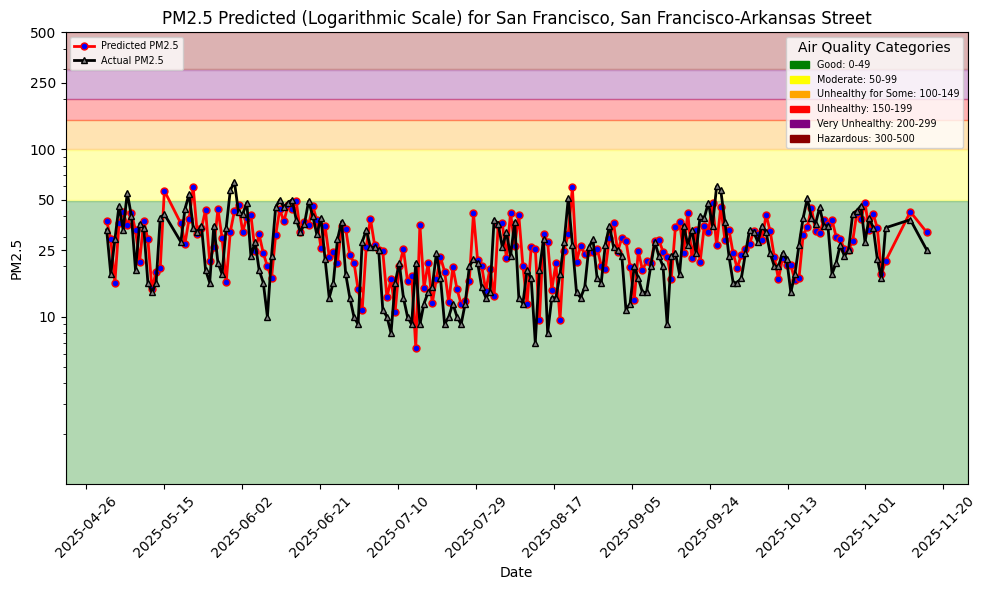

In [43]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

In [44]:
# Analyze feature importance to verify lag features are being used
import numpy as np

# Get feature importance scores
feature_importance = xgb_regressor.get_booster().get_score(importance_type='gain')
feature_names = list(feature_importance.keys())
importance_scores = list(feature_importance.values())

# Create a DataFrame for easier analysis
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance_scores
}).sort_values('importance', ascending=False)

print("=" * 60)
print("Feature Importance Analysis (to verify lag features impact)")
print("=" * 60)
print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

lag_features = ['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'pm25_roll_3']
print("\n" + "=" * 60)
print("Lag Feature Importance:")
print("=" * 60)
for lag_feat in lag_features:
    if lag_feat in importance_df['feature'].values:
        imp = importance_df[importance_df['feature'] == lag_feat]['importance'].values[0]
        rank = importance_df[importance_df['feature'] == lag_feat].index[0] + 1
        print(f"  {lag_feat}: Importance={imp:.2f}, Rank={rank}/{len(importance_df)}")
    else:
        print(f"  {lag_feat}: NOT FOUND (may have zero importance)")

total_lag_importance = importance_df[importance_df['feature'].isin(lag_features)]['importance'].sum()
total_importance = importance_df['importance'].sum()
print(f"\nTotal lag features importance: {total_lag_importance:.2f} ({total_lag_importance/total_importance*100:.1f}% of total)")
print("\n✓ Lag features ARE being used in the model if they appear above!")


Feature Importance Analysis (to verify lag features impact)

Top 10 Most Important Features:
                    feature  importance
                 pm25_lag_1 1941.916870
          precipitation_sum  251.539505
                pm25_roll_3  244.097641
        temperature_2m_mean  235.422073
wind_direction_10m_dominant  222.700638
                 pm25_lag_2  213.181427
         wind_speed_10m_max  207.622574
                 pm25_lag_3  199.457565

Lag Feature Importance:
  pm25_lag_1: Importance=1941.92, Rank=1/8
  pm25_lag_2: Importance=213.18, Rank=2/8
  pm25_lag_3: Importance=199.46, Rank=3/8
  pm25_roll_3: Importance=244.10, Rank=4/8

Total lag features importance: 2598.65 (73.9% of total)

✓ Lag features ARE being used in the model if they appear above!


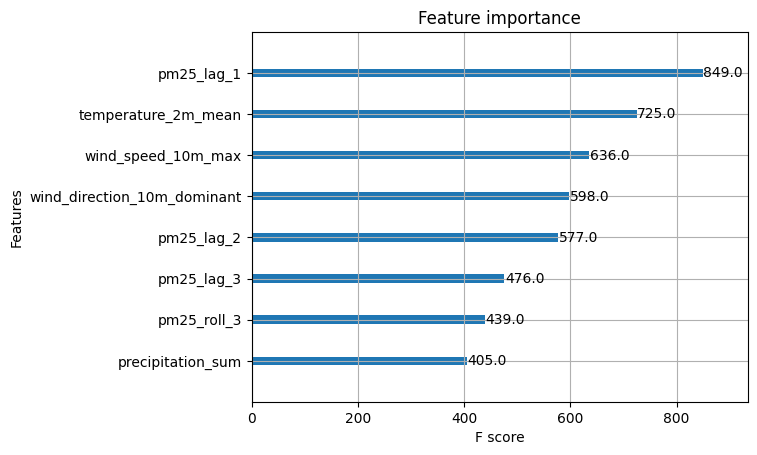

In [45]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [46]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [47]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [48]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'
# This version includes lag features (pm25_lag_1, pm25_lag_2, pm25_lag_3, pm25_roll_3)
# for Grade C requirement

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor with lag features (pm25_lag_1/2/3, pm25_roll_3) - Grade C",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

print(f"\n✓ Model saved as version {aq_model.version}")
print(f"✓ Compare this model's metrics with version 1 (without lag features) for Grade C evaluation")

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/sofieschnitzer/Desktop/KTH_HT25_filer/ID2223/mlfs-book_YairRT/notebooks/airquality/air_qualit…

Uploading /Users/sofieschnitzer/Desktop/KTH_HT25_filer/ID2223/mlfs-book_YairRT/notebooks/airquality/air_qualit…

Uploading /Users/sofieschnitzer/Desktop/KTH_HT25_filer/ID2223/mlfs-book_YairRT/notebooks/airquality/air_qualit…

Uploading /Users/sofieschnitzer/Desktop/KTH_HT25_filer/ID2223/mlfs-book_YairRT/notebooks/airquality/model_sche…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1293460/models/air_quality_xgboost_model/2

✓ Model saved as version 2
✓ Compare this model's metrics with version 1 (without lag features) for Grade C evaluation


---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
